# Feature Importance and Dimension Reduction

In [4]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from functools import reduce
from itertools import combinations
import seaborn as sns

In [5]:
# Load the encoded dataset
dataset_path = r"C:\Users\ghaza\Desktop\FYP\Application\AI\data\processed\encoded_dataset.csv"
data = pd.read_csv(dataset_path)

data.head()

Hydraulic_Pressure  Coolant_Pressure  Ambient_Temperature   Voltage  \
0           -0.039655          0.162988             0.420256 -0.114820   
1           -1.030087         -0.651692             0.074438 -0.541901   
2           -0.198730          1.782077            -0.774177 -0.520070   
3           -0.198730          0.177196             1.588168 -0.507840   
4           -0.275005         -0.367338             1.114265  0.414595   

   Humidity  Air_System_Pressure  Coolant_Temperature  \
0 -1.246888            -1.102778            -0.196436   
1 -0.989332             1.063464             0.079045   
2  1.099331            -0.146022             0.133280   
3 -1.029487            -0.744262            -1.044269   
4  0.584567            -0.213282            -1.095786   

   Hydraulic_Oil_Temperature  Water_Flow_Rate  Water_Temperature  \
0                  -0.148045        -1.263636          -0.122926   
1                   0.370359        -0.523880          -0.704583   
2                   0.618295        -0.109566           0.396435   
3                  -0.214292         0.862633           0.925815   
4                  -0.685844        -1.576164          -0.150508   

   Detergent_Level  Spray_Pressure  Vibration  Motor_Current  \
0         0.406296       -0.773212   0.436860      -1.015368   
1         0.313070       -0.127835   0.441334       0.249506   
2        -0.730996        0.883919   1.386255       1.809108   
3         3.361487       -0.207790   0.436516       0.293230   
4         0.192889       -0.907807  -1.152108      -0.421218   

   Pressure_Stability_Index  Temperature_Fluctuation_Index      failure_type  \
0                  0.797295                      -0.633333        No Failure   
1                  0.448922                       0.028935        No Failure   
2                 -0.815282                       0.071404  Water Flow Issue   
3                 -0.949388                      -0.217285        No Failure   
4                 -0.835525                       0.525137  Water Flow Issue   

   machine_failure  failure_type_encoded  
0                0                     1  
1                0                     1  
2                1                     4  
3                0                     1  
4                1                     4

In [6]:
# Define features and targets
features = data.drop(columns=["machine_failure", "failure_type_encoded", "failure_type"])
binary_target = data["machine_failure"]
multi_target = data["failure_type_encoded"]

# Split the dataset (70-30 split)
X_train, X_test, y_train_binary, y_test_binary, y_train_multi, y_test_multi = train_test_split(
    features,
    binary_target,
    multi_target,
    test_size=0.3,
    random_state=42,
    stratify=binary_target
)

### Step 1: Mutual Information Scores
##### Mutual Information (MI) measures the dependency between features and the target variable. Higher MI scores indicate features that have a strong dependency on the target variable.
- Retain features with high MI scores as they capture the non-linear relationships with the target.

In [8]:
# Calculate Mutual Information Scores
mi_binary = mutual_info_classif(features, binary_target, random_state=42)

# Combine MI scores into a DataFrame
mi_df = pd.DataFrame({
    "Feature": features.columns,
    "MI_Binary": mi_binary
})

# Display top features by MI
print("\nTop 10 Features by Mutual Information (Binary):")
print(mi_df.nlargest(10, "MI_Binary"))


Top 10 Features by Mutual Information (Binary):
                          Feature  MI_Binary
8                 Water_Flow_Rate   0.114914
10                Detergent_Level   0.113313
14       Pressure_Stability_Index   0.096653
0              Hydraulic_Pressure   0.060240
15  Temperature_Fluctuation_Index   0.055216
6             Coolant_Temperature   0.042990
7       Hydraulic_Oil_Temperature   0.041741
5             Air_System_Pressure   0.000824
4                        Humidity   0.000743
1                Coolant_Pressure   0.000043


### Step 2: Variance Threshold
##### Variance Threshold filters out features with low variance, which are less likely to be informative (e.g., almost constant features).

- Drop features with variance below the threshold as they provide little to no information.
- Retain only the features passing the threshold for the next steps.

In [10]:
# Calculate the variance of all features
feature_variances = features.var().sort_values(ascending=False)

# Initialize Variance Threshold with a minimum threshold
vt = VarianceThreshold(threshold=0.15)
vt.fit(features)

# Get features that passed the variance threshold
vt_features = features.columns[vt.get_support()].tolist()

# Print all features with their variances
print("\nFeature Variances:")
print(feature_variances)


Feature Variances:
Hydraulic_Pressure               1.000006
Voltage                          1.000006
Temperature_Fluctuation_Index    1.000006
Detergent_Level                  1.000006
Vibration                        1.000006
Air_System_Pressure              1.000006
Coolant_Pressure                 1.000006
Ambient_Temperature              1.000006
Humidity                         1.000006
Hydraulic_Oil_Temperature        1.000006
Water_Temperature                1.000006
Spray_Pressure                   1.000006
Motor_Current                    1.000006
Pressure_Stability_Index         1.000006
Water_Flow_Rate                  1.000006
Coolant_Temperature              1.000006
dtype: float64


### Step 3: Chi-Square Test (Binary Target Only)
##### Chi-Square test measures the independence between categorical features and the binary target. It works best for non-negative features (scaled here to [0, 1]).
- Retain features with the highest Chi-Square scores. Features with low Chi-Square scores have weaker independence and may be less useful for binary classification.


In [12]:
# Scale the features to [0, 1] range for Chi-Square compatibility
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Perform Chi-Square test
chi2_scores, chi2_pvalues = chi2(features_scaled, binary_target)

# Combine results into a DataFrame
chi2_df = pd.DataFrame({
    "Feature": features.columns,
    "Chi2_Score": chi2_scores,
    "P_Value": chi2_pvalues
})

# Display top features by Chi-Square score
top_chi2_features = chi2_df.nlargest(10, "Chi2_Score")["Feature"].tolist()  # Extract top 10 features
print("\nTop 10 Features by Chi-Square Test (Binary Target):")
print(chi2_df.nlargest(10, "Chi2_Score"))


Top 10 Features by Chi-Square Test (Binary Target):
                          Feature   Chi2_Score        P_Value
8                 Water_Flow_Rate  1469.482531   0.000000e+00
14       Pressure_Stability_Index  1260.330736  4.720760e-276
10                Detergent_Level  1106.375197  1.359176e-242
15  Temperature_Fluctuation_Index  1028.929260  9.250735e-226
6             Coolant_Temperature   754.403638  4.424822e-166
7       Hydraulic_Oil_Temperature   695.140917  3.406818e-153
0              Hydraulic_Pressure   659.201863  2.227967e-145
5             Air_System_Pressure    13.745715   2.092978e-04
11                 Spray_Pressure     2.003512   1.569352e-01
9               Water_Temperature     0.987414   3.203752e-01


### Step 4: ANOVA F-Test
##### ANOVA F-Test measures the linear relationship between numerical features and the binary target. Features with higher F-scores explain more variance in the target.
- Focus on features with high F-scores as they are more linearly correlated with the target.
- Consider combining these with other techniques (like MI) for a comprehensive feature set.

In [14]:
# Perform ANOVA F-Test
f_scores, f_pvalues = f_classif(features, binary_target)

# Combine results into a DataFrame
anova_df = pd.DataFrame({
    "Feature": features.columns,
    "F_Score": f_scores,
    "P_Value": f_pvalues
})

anova_features = anova_df.nlargest(10, "F_Score")["Feature"].tolist()
# Display top features by ANOVA F-Test
print("\nTop 10 Features by ANOVA F-Test (Binary Target):")
print(anova_df.nlargest(10, "F_Score"))


Top 10 Features by ANOVA F-Test (Binary Target):
                          Feature       F_Score       P_Value
8                 Water_Flow_Rate  29571.035529  0.000000e+00
14       Pressure_Stability_Index  23493.487207  0.000000e+00
10                Detergent_Level  22452.298878  0.000000e+00
0              Hydraulic_Pressure  18329.797183  0.000000e+00
15  Temperature_Fluctuation_Index  17300.470855  0.000000e+00
6             Coolant_Temperature  14082.650150  0.000000e+00
7       Hydraulic_Oil_Temperature  13436.347752  0.000000e+00
5             Air_System_Pressure    331.130938  6.380275e-74
11                 Spray_Pressure     57.877246  2.803801e-14
9               Water_Temperature     19.238221  1.154473e-05


### Step 5: Kolmogorov-Smirnov Test (KS Test)
##### KS Test identifies features with different distributions between the two classes in binary classification. A high KS statistic indicates a feature that is well-separated between classes.
- Retain features with the highest KS statistics as they are likely to provide better class discrimination.
- Discard features with low KS statistics as they don’t significantly differentiate between classes.


In [16]:
# Perform KS Test for each feature
ks_results = []
for feature in features.columns:
    ks_stat, ks_pvalue = ks_2samp(
        features[binary_target == 0][feature],
        features[binary_target == 1][feature]
    )
    ks_results.append((feature, ks_stat, ks_pvalue))

# Create DataFrame for KS Test results
ks_df = pd.DataFrame(ks_results, columns=["Feature", "KS_Statistic", "P_Value"])

ks_features = ks_df.nlargest(10, "KS_Statistic")["Feature"].tolist()

# Display top features by KS Test
print("\nTop 10 Features by KS Test (Binary Target):")
print(ks_df.nlargest(10, "KS_Statistic"))


Top 10 Features by KS Test (Binary Target):
                          Feature  KS_Statistic       P_Value
8                 Water_Flow_Rate      0.392465  0.000000e+00
14       Pressure_Stability_Index      0.363997  0.000000e+00
10                Detergent_Level      0.341722  0.000000e+00
15  Temperature_Fluctuation_Index      0.231937  0.000000e+00
7       Hydraulic_Oil_Temperature      0.227446  0.000000e+00
6             Coolant_Temperature      0.227110  0.000000e+00
0              Hydraulic_Pressure      0.215265  0.000000e+00
5             Air_System_Pressure      0.038154  1.257211e-44
11                 Spray_Pressure      0.013979  2.327421e-06
9               Water_Temperature      0.012757  2.282334e-05


In [17]:
# Feature lists obtained from various techniques
top_mi_features = mi_df["Feature"].tolist()  # From Mutual Information
top_variance_features = vt_features  # From Variance Threshold
top_chi2_features = top_chi2_features  # From Chi-Square Test
top_anova_features = anova_features  # From ANOVA F-Test
top_ks_features = ks_features  # From KS Test

# Combine features into a dictionary for better analysis
features_dict = {
    "Mutual Information": set(top_mi_features),
    "Variance Threshold": set(top_variance_features),
    "Chi-Square Test": set(top_chi2_features),
    "ANOVA F-Test": set(top_anova_features),
    "KS Test": set(top_ks_features),
}

In [18]:
# Find the intersection of features across all techniques
common_features_all = set.intersection(*features_dict.values())

# Display results
print("\nCommon Features Across All Techniques:")
print(common_features_all)


Common Features Across All Techniques:
{'Water_Flow_Rate', 'Temperature_Fluctuation_Index', 'Air_System_Pressure', 'Pressure_Stability_Index', 'Detergent_Level', 'Water_Temperature', 'Hydraulic_Oil_Temperature', 'Coolant_Temperature', 'Hydraulic_Pressure', 'Spray_Pressure'}


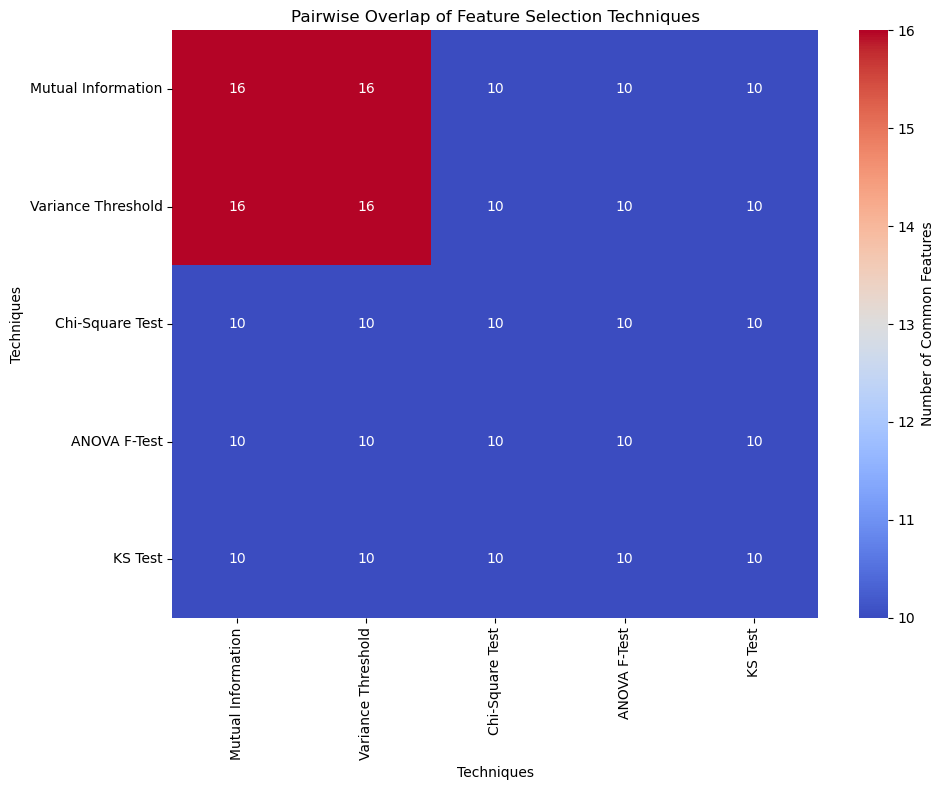

In [19]:
# Calculate pairwise overlaps between the techniques
overlap_matrix = pd.DataFrame(index=features_dict.keys(), columns=features_dict.keys())

for method1, method2 in combinations(features_dict.keys(), 2):
    overlap = len(features_dict[method1] & features_dict[method2])  # Intersection
    overlap_matrix.loc[method1, method2] = overlap
    overlap_matrix.loc[method2, method1] = overlap

# Fill diagonal with the total number of features for each method
for method in features_dict.keys():
    overlap_matrix.loc[method, method] = len(features_dict[method])

# Convert to numeric for heatmap
overlap_matrix = overlap_matrix.astype(int)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="coolwarm", cbar_kws={"label": "Number of Common Features"})
plt.title("Pairwise Overlap of Feature Selection Techniques")
plt.ylabel("Techniques")
plt.xlabel("Techniques")
plt.tight_layout()
plt.show()


In [20]:
# Threshold percentages for importance levels
high_threshold = 0.6  # Top 20% of normalized scores
medium_threshold = 0.3  # Next 30% of normalized scores

# Create a DataFrame for binary feature importance
binary_feature_importances = pd.DataFrame({
    "Feature": features.columns,
    "Mutual Information": mi_binary,  # From MI calculation
    "Variance Threshold": [0] * len(features.columns),  # Placeholder
    "Chi2_Score": chi2_df["Chi2_Score"],  # From Chi-Square Test
    "F_Score": anova_df["F_Score"],  # From ANOVA F-Test
    "KS_Score": ks_df["KS_Statistic"]  # From KS Test
})

# Normalize scores across all techniques (scale to [0, 1])
for col in binary_feature_importances.columns[1:]:
    binary_feature_importances[col] = binary_feature_importances[col] / binary_feature_importances[col].max()

# Calculate average importance across techniques
binary_feature_importances["Average Importance"] = binary_feature_importances.iloc[:, 1:].mean(axis=1)

# Define importance levels
binary_feature_importances["Importance Level"] = pd.cut(
    binary_feature_importances["Average Importance"],
    bins=[-float('inf'), medium_threshold, high_threshold, float('inf')],
    labels=["Low", "Medium", "High"]
)

# Separate features into categories
high_binary_features = binary_feature_importances[
    binary_feature_importances["Importance Level"] == "High"
]["Feature"].tolist()

medium_binary_features = binary_feature_importances[
    binary_feature_importances["Importance Level"] == "Medium"
]["Feature"].tolist()

low_binary_features = binary_feature_importances[
    binary_feature_importances["Importance Level"] == "Low"
]["Feature"].tolist()

# Print results
print("\nBinary Classification - High Importance Features:")
print(high_binary_features)
print("\nBinary Classification - Medium Importance Features:")
print(medium_binary_features)
print("\nBinary Classification - Low Importance Features:")
print(low_binary_features)

# Save binary importance summary
binary_feature_importances.sort_values(by="Average Importance", ascending=False, inplace=True)
binary_feature_importances.reset_index(drop=True, inplace=True)



Binary Classification - High Importance Features:
['Water_Flow_Rate', 'Detergent_Level', 'Pressure_Stability_Index']

Binary Classification - Medium Importance Features:
['Hydraulic_Pressure', 'Coolant_Temperature', 'Hydraulic_Oil_Temperature', 'Temperature_Fluctuation_Index']

Binary Classification - Low Importance Features:
['Coolant_Pressure', 'Ambient_Temperature', 'Voltage', 'Humidity', 'Air_System_Pressure', 'Water_Temperature', 'Spray_Pressure', 'Vibration', 'Motor_Current']


In [21]:
# Mutual Information for Multi-Class
mi_multi = mutual_info_classif(features, multi_target, random_state=42)

mi_multi_df = pd.DataFrame({
    "Feature": features.columns,
    "MI_Multi": mi_multi
}).sort_values(by="MI_Multi", ascending=False)

print("\nTop 10 Features by Mutual Information (Multi-Class):")
print(mi_multi_df.head(10))


Top 10 Features by Mutual Information (Multi-Class):
                          Feature  MI_Multi
15  Temperature_Fluctuation_Index  0.162409
10                Detergent_Level  0.132234
14       Pressure_Stability_Index  0.123817
6             Coolant_Temperature  0.115427
8                 Water_Flow_Rate  0.115015
7       Hydraulic_Oil_Temperature  0.110631
0              Hydraulic_Pressure  0.063888
5             Air_System_Pressure  0.008021
1                Coolant_Pressure  0.001013
3                         Voltage  0.000362


In [22]:
# Chi-Square Test for Multi-Class
# Scale the features to [0, 1] range for Chi-Square compatibility
features_scaled = MinMaxScaler().fit_transform(features)
chi2_scores_multi, chi2_pvalues_multi = chi2(features_scaled, multi_target)

chi2_multi_df = pd.DataFrame({
    "Feature": features.columns,
    "Chi2_Score": chi2_scores_multi,
    "P_Value": chi2_pvalues_multi
}).sort_values(by="Chi2_Score", ascending=False)

print("\nTop 10 Features by Chi-Square Test (Multi-Class):")
print(chi2_multi_df.head(10))


Top 10 Features by Chi-Square Test (Multi-Class):
                          Feature   Chi2_Score        P_Value
15  Temperature_Fluctuation_Index  4145.987463   0.000000e+00
6             Coolant_Temperature  2463.630881   0.000000e+00
7       Hydraulic_Oil_Temperature  2236.764139   0.000000e+00
14       Pressure_Stability_Index  1578.455727   0.000000e+00
8                 Water_Flow_Rate  1469.855275   0.000000e+00
10                Detergent_Level  1254.347255  2.630474e-270
0              Hydraulic_Pressure   722.588252  4.477299e-155
5             Air_System_Pressure    81.047445   1.044882e-16
1                Coolant_Pressure    11.172884   2.468823e-02
11                 Spray_Pressure     3.573484   4.667932e-01


In [23]:
# ANOVA F-Test for Multi-Class
f_scores_multi, f_pvalues_multi = f_classif(features, multi_target)

anova_multi_df = pd.DataFrame({
    "Feature": features.columns,
    "F_Score": f_scores_multi,
    "P_Value": f_pvalues_multi
}).sort_values(by="F_Score", ascending=False)

print("\nTop 10 Features by ANOVA F-Test (Multi-Class):")
print(anova_multi_df.head(10))



Top 10 Features by ANOVA F-Test (Multi-Class):
                          Feature       F_Score       P_Value
15  Temperature_Fluctuation_Index  24881.023955  0.000000e+00
6             Coolant_Temperature  14061.569857  0.000000e+00
7       Hydraulic_Oil_Temperature  13027.195741  0.000000e+00
14       Pressure_Stability_Index   7613.841154  0.000000e+00
8                 Water_Flow_Rate   7394.824349  0.000000e+00
10                Detergent_Level   6474.819790  0.000000e+00
0              Hydraulic_Pressure   5074.112672  0.000000e+00
5             Air_System_Pressure    492.660454  0.000000e+00
1                Coolant_Pressure     67.213498  6.236676e-57
11                 Spray_Pressure     25.813863  2.022741e-21


In [24]:
# Initialize dictionary to store KS statistics for each feature
ks_results_multi = {feature: [] for feature in features.columns}

# Iterate through each class in the multi-class target
for class_label in multi_target.unique():
    print(f"\nRunning KS Test for class '{class_label}'...")
    
    # Create binary target: 1 for the current class, 0 for the rest
    binary_class_target = (multi_target == class_label).astype(int)
    
    # Compute KS statistic for each feature
    for feature in features.columns:
        feature_values_class = features[binary_class_target == 1][feature]
        feature_values_non_class = features[binary_class_target == 0][feature]
        
        # Perform KS Test
        ks_stat, p_value = ks_2samp(feature_values_class, feature_values_non_class)
        
        # Store results
        ks_results_multi[feature].append(ks_stat)

# Average KS statistics across all classes for each feature
ks_avg_multi = {feature: sum(stats) / len(stats) for feature, stats in ks_results_multi.items()}

# Combine results into a DataFrame
ks_multi_df = pd.DataFrame({
    "Feature": ks_avg_multi.keys(),
    "Average_KS_Statistic": ks_avg_multi.values()
}).sort_values(by="Average_KS_Statistic", ascending=False)

# Display top 10 features by KS statistic
print("\nTop 10 Features by KS Test (Multi-Class):")
print(ks_multi_df.head(10))


Running KS Test for class '1'...

Running KS Test for class '4'...

Running KS Test for class '3'...

Running KS Test for class '0'...

Running KS Test for class '2'...

Top 10 Features by KS Test (Multi-Class):
                          Feature  Average_KS_Statistic
14       Pressure_Stability_Index              0.328593
8                 Water_Flow_Rate              0.323798
10                Detergent_Level              0.311250
15  Temperature_Fluctuation_Index              0.250149
7       Hydraulic_Oil_Temperature              0.209275
6             Coolant_Temperature              0.208067
0              Hydraulic_Pressure              0.174559
5             Air_System_Pressure              0.081376
1                Coolant_Pressure              0.034003
11                 Spray_Pressure              0.016154


In [25]:
# Create a DataFrame for multi-class feature importance
multi_feature_importances = pd.DataFrame({
    "Feature": features.columns,
    "Mutual Information": mi_multi,  # From MI calculation
    "Variance Threshold": [0] * len(features.columns),  # Placeholder
    "Chi2_Score": chi2_df["Chi2_Score"],  # From Chi-Square Test (if applicable to multi-class)
    "F_Score": anova_df["F_Score"],  # From ANOVA F-Test
    "KS_Score": ks_df["KS_Statistic"]  # From KS Test
})

# Normalize scores across all techniques (scale to [0, 1])
for col in multi_feature_importances.columns[1:]:
    multi_feature_importances[col] = multi_feature_importances[col] / multi_feature_importances[col].max()

# Calculate average importance across techniques
multi_feature_importances["Average Importance"] = multi_feature_importances.iloc[:, 1:].mean(axis=1)

# Define importance levels
multi_feature_importances["Importance Level"] = pd.cut(
    multi_feature_importances["Average Importance"],
    bins=[-float('inf'), medium_threshold, high_threshold, float('inf')],
    labels=["Low", "Medium", "High"]
)

# Separate features into categories
high_multi_features = multi_feature_importances[
    multi_feature_importances["Importance Level"] == "High"
]["Feature"].tolist()

medium_multi_features = multi_feature_importances[
    multi_feature_importances["Importance Level"] == "Medium"
]["Feature"].tolist()

low_multi_features = multi_feature_importances[
    multi_feature_importances["Importance Level"] == "Low"
]["Feature"].tolist()

# Print results
print("\nMulti-Class Classification - High Importance Features:")
print(high_multi_features)
print("\nMulti-Class Classification - Medium Importance Features:")
print(medium_multi_features)
print("\nMulti-Class Classification - Low Importance Features:")
print(low_multi_features)

# Save multi-class importance summary
multi_feature_importances.sort_values(by="Average Importance", ascending=False, inplace=True)
multi_feature_importances.reset_index(drop=True, inplace=True)



Multi-Class Classification - High Importance Features:
['Water_Flow_Rate', 'Detergent_Level', 'Pressure_Stability_Index', 'Temperature_Fluctuation_Index']

Multi-Class Classification - Medium Importance Features:
['Hydraulic_Pressure', 'Coolant_Temperature', 'Hydraulic_Oil_Temperature']

Multi-Class Classification - Low Importance Features:
['Coolant_Pressure', 'Ambient_Temperature', 'Voltage', 'Humidity', 'Air_System_Pressure', 'Water_Temperature', 'Spray_Pressure', 'Vibration', 'Motor_Current']


In [26]:
# Find common features in high importance categories
common_high_features = list(set(high_binary_features) & set(high_multi_features))

# Find common features in medium importance categories
common_medium_features = list(set(medium_binary_features) & set(medium_multi_features))

# Find common low-importance features
common_low_features = list(set(low_binary_features) & set(low_multi_features))

# Print results
print("\nCommon High Importance Features Across Binary and Multi-Class:")
print(common_high_features)
print("\nCommon Medium Importance Features Across Binary and Multi-Class:")
print(common_medium_features)
print("\nCommon Low Importance Features Across Binary and Multi-Class:")
print(common_low_features)



Common High Importance Features Across Binary and Multi-Class:
['Water_Flow_Rate', 'Pressure_Stability_Index', 'Detergent_Level']

Common Medium Importance Features Across Binary and Multi-Class:
['Hydraulic_Pressure', 'Hydraulic_Oil_Temperature', 'Coolant_Temperature']

Common Low Importance Features Across Binary and Multi-Class:
['Coolant_Pressure', 'Air_System_Pressure', 'Water_Temperature', 'Ambient_Temperature', 'Vibration', 'Motor_Current', 'Humidity', 'Voltage', 'Spray_Pressure']


In [27]:
high_importance_features = list(set(high_binary_features + high_multi_features))
medium_importance_features = list(set(medium_binary_features + medium_multi_features))
low_importance_features = list(set(low_binary_features + low_multi_features))

# Print results
print("\nHigh Importance Features Across Binary and Multi-Class:")
print(high_importance_features)
print("\nMedium Importance Features Across Binary and Multi-Class:")
print(medium_importance_features)
print("\nLow Importance Features Across Binary and Multi-Class:")
print(low_importance_features)


High Importance Features Across Binary and Multi-Class:
['Water_Flow_Rate', 'Temperature_Fluctuation_Index', 'Pressure_Stability_Index', 'Detergent_Level']

Medium Importance Features Across Binary and Multi-Class:
['Hydraulic_Pressure', 'Temperature_Fluctuation_Index', 'Hydraulic_Oil_Temperature', 'Coolant_Temperature']

Low Importance Features Across Binary and Multi-Class:
['Coolant_Pressure', 'Air_System_Pressure', 'Ambient_Temperature', 'Water_Temperature', 'Vibration', 'Motor_Current', 'Humidity', 'Voltage', 'Spray_Pressure']


In [28]:
# Order-preserving removal of duplicates:
selected_features = []
for feature in high_importance_features + medium_importance_features:
    if feature not in selected_features:
        selected_features.append(feature)

# Ensure that the target variables are included
selected_features += ['machine_failure', 'failure_type_encoded']  # Binary and Multi-class targets

# Filter the dataset to include only the selected features
unified_dataset = data[selected_features]

# Print a summary of the unified dataset
print("Unified Dataset Summary:")
print(unified_dataset.info())
print("\nFirst few rows of the unified dataset:")
print(unified_dataset.head())

Unified Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174954 entries, 0 to 174953
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Water_Flow_Rate                174954 non-null  float64
 1   Temperature_Fluctuation_Index  174954 non-null  float64
 2   Pressure_Stability_Index       174954 non-null  float64
 3   Detergent_Level                174954 non-null  float64
 4   Hydraulic_Pressure             174954 non-null  float64
 5   Hydraulic_Oil_Temperature      174954 non-null  float64
 6   Coolant_Temperature            174954 non-null  float64
 7   machine_failure                174954 non-null  int64  
 8   failure_type_encoded           174954 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 12.0 MB
None

First few rows of the unified dataset:
   Water_Flow_Rate  Temperature_Fluctuation_Index  Pressure_Stability_Index  \
0        -1.263636 

In [29]:
# Save the unified dataset for further use
file_path = "C:/Users/ghaza/Desktop/FYP/Application/AI/data/processed/preprocessed_data.csv"
unified_dataset.to_csv(file_path, index=False)
print(f"\nUnified dataset saved to {file_path}")


Unified dataset saved to C:/Users/ghaza/Desktop/FYP/Application/AI/data/processed/preprocessed_data.csv
